In [1]:
# Some of the functions below require an older version of torchtext than the default one Kaggle gives you.
# IMPORTANT: Make sure that Internet is turned on!!! (Notebook options in the bar on the right)
# IMPORTANT: If you're not already using Kaggle, we STRONGLY recommend you switch to Kaggle for hw1b in particular,
# because copying our notebook will pin you to a Python version that lets you install the right version of torchtext.
# On Colab you will have to downgrade your Python to e.g., 3.7 to do the below pip install, which is a pain to do.
!pip install torchtext==0.10.0
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 913.7 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.9.0 requires torch>=1.10.0, but you have torch 1.9.0 which is incompatible.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.9.0 which is incompatible.


In [3]:
# This block handles some basic setup and data loading.  
# You shouldn't need to edit this, but if you want to 
# import other standard python packages, that is fine.

# imports
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext

from torchtext.legacy import data
from torchtext.legacy import datasets

# download and load the data
text_field = data.Field()
datasets = datasets.WikiText2.splits(root='.', text_field=text_field)

train_dataset, validation_dataset, test_dataset = datasets

text_field.build_vocab(train_dataset, validation_dataset, test_dataset)
vocab = text_field.vocab
vocab_size = len(vocab)

train_text = train_dataset.examples[0].text # a list of tokens (strings)
validation_text = validation_dataset.examples[0].text

print(validation_text[:30])

['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


In [2]:
text_field.vocab.freqs['.']

90077

In [4]:
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext

We've implemented a unigram model here as a demonstration.

In [5]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in vocab.itos]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.
        
        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter 
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:', 
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities, 
    it is still good to have a separate more efficient method that only computes 
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab.stoi[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [6]:
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(vocab.itos, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> winning Its its younger . 1961 life feminine The should indie = of under of Files of superstructure Moon ,


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature.  You can read more about sampling from a language model in this recent paper: https://arxiv.org/pdf/1904.09751.pdf.

You will need to submit some outputs from the models you implement for us to grade.  The following function will be used to generate the required output files.

In [8]:
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes_short.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab_short.txt

def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.
    
    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    from tqdm import tqdm

    vocab_name = 'eval_output_vocab'
    prefixes_name = 'eval_prefixes'

    if short: 
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab.stoi[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in tqdm(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

--2023-09-08 16:27:55--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519055 (507K) [text/plain]
Saving to: ‘eval_prefixes.txt.1’

eval_prefixes.txt.1 100%[===================>] 506.89K  --.-KB/s    in 0.05s   

2023-09-08 16:27:55 (10.0 MB/s) - ‘eval_prefixes.txt.1’ saved [519055/519055]

--2023-09-08 16:27:56--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12497 (12K) [text/plain]
Saving to: ‘eval_output_vocab.txt.1’

eval_o

In [9]:
save_truncated_distribution(unigram_demonstration_model, 
                            'unigram_demonstration_predictions.npy')

saved unigram_demonstration_predictions.npy


### N-gram Model

Now it's time to implement an n-gram language model.

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{C(w_1,w_2)+\alpha}{C(w_1)+N\alpha}$$

where $N$ is the vocab size and $C$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff.

One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity below 510 on the validation set.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass. 
Also, we suggest pre-computing and caching the counts $C$ when you initialize `NGramModel` for efficiency. 

In [10]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha
        self.vocab = set(train_text)
        self.vocab_size = len(self.vocab)
        self.alpha = alpha

        # YOUR CODE HERE
        self.n_gram_counts = Counter([tuple(train_text[i:i+n]) for i in range(len(train_text)-n+1)])
        self.n_1_gram_counts = Counter([tuple(train_text[i:i+n-1]) for i in range(len(train_text)-n+2)])


    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.
        
        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n

        # YOUR CODE HERE
        n_1_gram = tuple(n_gram[:-1])
        numerator = self.n_gram_counts.get(tuple(n_gram), 0) + self.alpha
        denominator = self.n_1_gram_counts.get(n_1_gram, 0) + self.vocab_size * self.alpha
        return numerator / denominator



    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""

        # YOUR CODE HERE
        # use your function n_gram_probability
        # vocab.itos contains a list of words to return probabilities for
        probabilities = []
        
        if len(text_prefix) < self.n - 1:
            return [1 / self.vocab_size for _ in self.vocab]
        
        text_prefix = text_prefix[-(self.n - 1):] if self.n > 1 else []
        
        for word in vocab.itos:
            n_gram = text_prefix + [word]
            prob = self.n_gram_probability(n_gram)
            probabilities.append(prob)
        
        return probabilities
        


    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """
        N = len(full_text)
        prob = []
        
        # Handle the first n-1 words as a special case (uniform distribution)
        for i in range(min(self.n - 1, N)):
            prob.append(math.log(1 / self.vocab_size))
        
        # Compute perplexity for the rest of the text
        for i in range(self.n - 1, N):
            n_gram = full_text[i-self.n+1:i+1]
            prob.append(math.log(self.n_gram_probability(n_gram)))
        
        return math.exp(-np.mean(prob))
        # YOUR CODE HERE
        # use your function n_gram_probability
        # This method should differ a bit from the example unigram model because 
        # the first n-1 words of full_text must be handled as a special case.



unigram_model = NGramModel(train_text, 1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 965.0918293231176
bigram validation perplexity: 504.4263037850708
trigram validation perplexity: 2965.604234400349


saved bigram_predictions.npy


Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: ***504.4263037850708***

We can also generate samples from the model to get an idea of how it is doing.

In [11]:
print(generate_text(bigram_model))

<eos> <eos> <eos> In Britain twenty @-@ watched by a fountain display AM convert boxer . The structures listed in the period


We now free up some RAM, **it is important to run the cell below, otherwise you may quite possibly run out of RAM in the runtime.**

In [12]:
# Free up some RAM. 
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting.
$$P\left(w_i|w_{i-n+1}^{i-1}\right)=\frac{max\left\{C(w_{i-n+1}^i)-\delta,0\right\}}{\sum_{w_i} C(w_{i-n+1}^i)} + \alpha(w_{i-n+1}^{i-1}) P(w_i|w_{i-n+2}^{i-1})$$

$$\alpha\left(w_{i-n+1}^{i-1}\right)=\frac{\delta N_{1+}(w_{i-n+1}^{i-1})}{{\sum_{w_i} C(w_{i-n+1}^i)}}$$
where $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $\sum_{w_i} C(w_{i-n+1}^i)=0$, use the lower order model probability directly (the above equations would have a division by 0).

We found a discount $\delta$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 275.

In [13]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta
        self.N1plus = defaultdict(int)
        for n_gram, c in self.n_gram_counts.items():
            if c > 0:
                self.N1plus[n_gram[:-1]] += 1

        

    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n
        n_gram = tuple(n_gram)
        n_1_gram = tuple(n_gram[:-1])

        count_n_gram = self.n_gram_counts[n_gram]
        count_n_1_gram = self.n_1_gram_counts[n_1_gram]
#         count_n_1_gram = sum([c for ng, c in self.n_gram_counts.items() if ng[:-1] == n_1_gram])
        
        if count_n_1_gram == 0:
            return self.lower_order_model.n_gram_probability(n_gram[1:])

        max_term = max(count_n_gram - self.discount, 0) / count_n_1_gram
        alpha = self.discount * self.N1plus[n_1_gram] / count_n_1_gram
        lower_order_prob = self.lower_order_model.n_gram_probability(n_gram[1:])

        return max_term + alpha * lower_order_prob



bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

trigram backoff validation perplexity: 271.1218574337853


Free up RAM. 

In [14]:
# Release models we don't need any more. 
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Fill in your trigram backoff perplexity here.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: ***271.1218574337853***



Free up RAM. 

### Neural N-gram Model

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity below 226.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total). 
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with `nn.Linear`, then using `F.embedding` with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see Project 0)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, though.

In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab.stoi['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y


class NeuralNGramNetwork(nn.Module):
    def __init__(self, n, embed_dim=128, hidden_dim=1024, dropout=0.1):
        super(NeuralNGramNetwork, self).__init__()
        self.n = n
        self.embed_dim = embed_dim

        # Create the final layer first for weight tying
        self.fc_final = nn.Linear(embed_dim, vocab_size)

        # First two hidden layers with ReLU and dropout
        self.fc1 = nn.Linear((n-1) * embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)

        # Dimension reduction layer without ReLU
        self.fc3 = nn.Linear(hidden_dim, embed_dim)


    def forward(self, x):
        x = x.long()  # Convert to Long type

        # Use F.embedding and the weights of the final linear layer for embedding
        x = F.embedding(x, self.fc_final.weight)

        x = x.view(-1, (self.n - 1) * self.embed_dim)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc_final(x)
        
        return F.log_softmax(x, dim=-1)
    
        
        



class NeuralNGramModel:
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).cuda()
        self.optimizer = optim.Adam(self.network.parameters())
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=3)

    def train(self):
        min_val_perplexity = float('inf')
        epochs_without_improvement = 0

        self.network.train()
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in range(10):
            pbar = tqdm(train_loader)
            for x, y in pbar:
                x, y = x.cuda(), y.cuda()
                self.optimizer.zero_grad()
                output = self.network(x)
                loss = F.nll_loss(output, y)
                loss.backward()
                self.optimizer.step()
                pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

            val_perplexity = self.perplexity(validation_text)  # Assuming validation_text is defined
            print(f"Validation Perplexity after epoch {epoch+1}: {val_perplexity}")

            # Early stopping and learning rate scheduling
            if val_perplexity < min_val_perplexity:
                min_val_perplexity = val_perplexity
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= 1:
                    print("Early stopping due to no improvement in validation perplexity.")
                    break

            self.scheduler.step(val_perplexity)

    
    def next_word_probabilities(self, text_prefix):
        self.network.eval()
        with torch.no_grad():
            # Handle the case where text_prefix has fewer than n-1 tokens
            if len(text_prefix) < self.n - 1:
                text_prefix = ['<eos>'] * (self.n - 1 - len(text_prefix)) + text_prefix

            x = torch.tensor(ids(text_prefix[-self.n+1:])).unsqueeze(0).cuda()

            # Check that x is not empty
            if x.nelement() == 0:
                return []

            output = self.network(x)
            probs = torch.exp(output).squeeze().cpu().numpy()

            # Check that probs is not empty
            if len(probs) == 0:
                return []

            return probs


    def perplexity(self, text):
        self.network.eval()
        dataset = NeuralNgramDataset(ids(text), self.n)
        data_loader = DataLoader(dataset, batch_size=128)
        total_loss = 0
        total_count = 0
        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.cuda(), y.cuda()
                output = self.network(x)
                loss = F.nll_loss(output, y, reduction='sum').item()
                total_loss += loss
                total_count += y.size(0)
        return torch.exp(torch.tensor(total_loss / total_count)).item()

neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy', short=False)

Epoch 1 Loss: 6.2276: 100%|██████████| 16318/16318 [02:36<00:00, 104.52it/s]


Validation Perplexity after epoch 1: 235.6413116455078


Epoch 2 Loss: 4.8589: 100%|██████████| 16318/16318 [02:35<00:00, 105.27it/s]


Validation Perplexity after epoch 2: 211.1413116455078


Epoch 3 Loss: 6.0954: 100%|██████████| 16318/16318 [02:33<00:00, 106.03it/s]


Validation Perplexity after epoch 3: 209.91098022460938


Epoch 4 Loss: 5.5778: 100%|██████████| 16318/16318 [02:35<00:00, 105.13it/s]


Validation Perplexity after epoch 4: 213.18162536621094
Early stopping due to no improvement in validation perplexity.
neural trigram validation perplexity: 213.18162536621094


saved neural_trigram_predictions.npy


Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: ***213.18162536621094***

Free up RAM.

In [20]:
# Delete model we don't need. 
del neural_trigram_model

### LSTM Model

For this stage of the project, you will implement an LSTM language model.

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We'll use the `torchtext` library to manage this batching for you.  To properly deal with this input format, you should save the last state of the LSTM from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity below 130.  The following architecture and hyperparameters should be sufficient to get there.
* 3 LSTM layers with 512 units
* dropout of 0.5 after each LSTM layer
* instead of projecting directly from the last LSTM output to the vocabulary size for softmax, project down to a smaller size first (e.g. 512->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 20 epochs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data
import torch.nn.functional as F
from tqdm import tqdm

# Assuming vocab and train_dataset are defined and loaded somewhere
# vocab.stoi is a dictionary that converts string to index
# train_dataset is a dataset object

def ids(tokens):
    return [vocab.stoi[t] for t in tokens]


class LSTMNetwork(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_layers=3, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, embed_size)
        self.fc2 = nn.Linear(embed_size, vocab_size)
        self.fc2.weight = self.embedding.weight  # Tie weights

    def forward(self, x, state):
        x = self.embedding(x)
        x, new_state = self.lstm(x, state)
        x = self.fc1(x)
        x = self.fc2(x)
        return x, new_state

class LSTMModel:
    def __init__(self):
        vocab_size = len(train_dataset.fields['text'].vocab)
        self.network = LSTMNetwork(vocab_size).cuda()
        self.optimizer = optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        

    def train(self):
        epochs = 25
        epochs_without_improvement = 0
        min_val_perplexity = float('inf')
        epoch_loss = 0
        for epoch in range(epochs):
            self.network.train()
            state_h, state_c = torch.zeros(3, 64, 512).cuda(), torch.zeros(3, 64, 512).cuda()
            train_iterator = data.BPTTIterator(train_dataset, batch_size=64, bptt_len=32, device='cuda')
            pbar = tqdm(train_iterator, position=0, leave=True)  # Initialize tqdm
            
            for batch in pbar:
                self.optimizer.zero_grad()
                output, (state_h, state_c) = self.network(batch.text, (state_h.detach(), state_c.detach()))
                loss = self.criterion(output.view(-1, output.size(2)), batch.target.view(-1))
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                
                pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
            val_perplexity = self.dataset_perplexity(validation_dataset)
            print(f"Validation Perplexity after Epoch {epoch+1}: {val_perplexity}")
            if val_perplexity < min_val_perplexity:
                min_val_perplexity = val_perplexity
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= 2:
                    print("Early stopping due to no improvement in validation perplexity.")
                    break
                    
    def next_word_probabilities(self, text_prefix):
        self.network.eval()
        with torch.no_grad():
            prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
            output, _ = self.network(prefix_token_tensor, None)
            probs = torch.exp(output[-1]).squeeze().cpu().numpy()
        return probs

    def dataset_perplexity(self, torchtext_dataset):
        self.network.eval()
        vocab_size = len(torchtext_dataset.fields['text'].vocab)
        total_loss = 0
        total_count = 0
        iterator = data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')
        with torch.no_grad():
            state_h, state_c = torch.zeros(3, 64, 512).cuda(), torch.zeros(3, 64, 512).cuda()
            for batch in iterator:
                output, (state_h, state_c) = self.network(batch.text, (state_h.detach(), state_c.detach()))
                loss = self.criterion(output.view(-1, vocab_size), batch.target.view(-1))
                total_loss += loss.item() * np.prod(batch.target.shape)
                total_count += np.prod(batch.target.shape)
        perplexity = np.exp(total_loss / total_count)
        return perplexity
    

# Assuming train_dataset and validation_dataset are already prepared
lstm_model = LSTMModel()
lstm_model.train()

print('Final LSTM validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))


Epoch 1 Loss: 6.3552:  77%|███████▋  | 785/1020 [00:48<00:14, 16.37it/s]

In [24]:
save_truncated_distribution(lstm_model, 'lstm_predictions.npy', short=False)

saved lstm_predictions.npy


In [ ]:
del lstm_model

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your LSTM perplexity. 

LSTM validation perplexity: ***129.35680852165908***

# Experimentation: 1-Page Report

Now it's time for you to experiment.  Try to reach a validation perplexity below 120. You may either modify the LSTM class above, or copy it down to the code cell below and modify it there. Just **be sure to run code cell below to generate results with your improved LSTM**.  

It is okay if the bulk of your improvements are due to hyperparameter tuning (such as changing number or sizes of layers), but implement at least one more substantial change to the model.  Here are some ideas (several of which come from https://arxiv.org/pdf/1708.02182.pdf):
* activation regularization - add a l2 regularization penalty on the activation of the LSTM output (standard l2 regularization is on the weights)
* weight-drop regularization - apply dropout to the weight matrices instead of activations
* learning rate scheduling - decrease the learning rate during training
* embedding dropout - zero out the entire embedding for a random set of words in the embedding matrix
* ensembling - average the predictions of several models trained with different initialization random seeds
* temporal activation regularization - add l2 regularization on the difference between the LSTM output activations at adjacent timesteps

You may notice that most of these suggestions are regularization techniques.  This dataset is considered fairly small, so regularization is one of the best ways to improve performance.

For this section, you will submit a write-up describing the extensions and/or modifications that you tried.  Your write-up should be **1-page maximum** in length and should be submitted in PDF format.  You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf.
For full credit, your write-up should include:
1.   A concise and precise description of the extension that you tried.
2.   A motivation for why you believed this approach might improve your model.
3.   A discussion of whether the extension was effective and/or an analysis of the results.  This will generally involve some combination of tables, learning curves, etc.
4.   A bottom-line summary of your results comparing validation perplexities of your improvement to the original LSTM.
The purpose of this exercise is to experiment, so feel free to try/ablate multiple of the suggestions above as well as any others you come up with!
When you submit the file, please name it `report.pdf`.



Run the cell below in order to train your improved LSTM and evaluate it.  

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# Assuming vocab and train_dataset are defined and loaded somewhere
# vocab.stoi is a dictionary that converts string to index
# train_dataset is a dataset object

def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

class LSTMNetwork(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_layers=3, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, embed_size)
        self.fc2 = nn.Linear(embed_size, vocab_size)
        self.fc2.weight = self.embedding.weight  # Tie weights

    def forward(self, x, state):
        x = self.embedding(x)
        x, new_state = self.lstm(x, state)
        x = self.fc1(x)
        x = self.fc2(x)
        return x, new_state

class LSTMModel:
    def __init__(self):
        vocab_size = len(train_dataset.fields['text'].vocab)
        self.network = LSTMNetwork(vocab_size).cuda()
        self.optimizer = optim.AdamW(self.network.parameters(), lr=0.004, weight_decay=0.02)
        self.criterion = nn.CrossEntropyLoss()
        self.activation_reg = 0.001  # Hyperparameter for activation regularization

    def train(self):
        epochs = 25
        epochs_without_improvement = 0
        min_val_perplexity = float('inf')
        
        for epoch in range(epochs):
            self.network.train()
            state_h, state_c = torch.zeros(3, 64, 512).cuda(), torch.zeros(3, 64, 512).cuda()
            train_iterator = data.BPTTIterator(train_dataset, batch_size=64, bptt_len=32, device='cuda')
            pbar = tqdm(train_iterator, position=0, leave=True)
            
            for batch in pbar:
                self.optimizer.zero_grad()
                output, (state_h, state_c) = self.network(batch.text, (state_h.detach(), state_c.detach()))
                
                # Activation Regularization
                ar_loss = self.activation_reg * torch.norm(state_h, 2)
                
                loss = self.criterion(output.view(-1, output.size(2)), batch.target.view(-1)) + ar_loss
                loss.backward()
                self.optimizer.step()
                
                pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
            
            val_perplexity = self.dataset_perplexity(validation_dataset)
            print(f"Validation Perplexity after Epoch {epoch+1}: {val_perplexity}")
            if val_perplexity < 120:
                print("Achieved goal in validation perplexity.")
                break

    def next_word_probabilities(self, text_prefix):
        self.network.eval()
        with torch.no_grad():
            prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
            output, _ = self.network(prefix_token_tensor, None)
            probs = torch.exp(output[-1]).squeeze().cpu().numpy()
        return probs

    def dataset_perplexity(self, torchtext_dataset):
        self.network.eval()
        vocab_size = len(torchtext_dataset.fields['text'].vocab)
        total_loss = 0
        total_count = 0
        iterator = data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')
        with torch.no_grad():
            state_h, state_c = torch.zeros(3, 64, 512).cuda(), torch.zeros(3, 64, 512).cuda()
            for batch in iterator:
                output, (state_h, state_c) = self.network(batch.text, (state_h.detach(), state_c.detach()))
                loss = self.criterion(output.view(-1, vocab_size), batch.target.view(-1))
                total_loss += loss.item() * np.prod(batch.target.shape)
                total_count += np.prod(batch.target.shape)
        perplexity = np.exp(total_loss / total_count)
        return perplexity

# Assuming train_dataset and validation_dataset are already prepared
lstm_model = LSTMModel()
lstm_model.train()

print('Final LSTM validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))


Epoch 1 Loss: 5.8793: 100%|██████████| 1020/1020 [01:02<00:00, 16.24it/s]


Validation Perplexity after Epoch 1: 269.3469392054884


Epoch 2 Loss: 5.3630: 100%|██████████| 1020/1020 [01:02<00:00, 16.24it/s]


Validation Perplexity after Epoch 2: 188.69458503512863


Epoch 3 Loss: 5.1448: 100%|██████████| 1020/1020 [01:02<00:00, 16.22it/s]


Validation Perplexity after Epoch 3: 157.4866147808746


Epoch 4 Loss: 4.9047: 100%|██████████| 1020/1020 [01:02<00:00, 16.21it/s]


Validation Perplexity after Epoch 4: 141.2383748990779


Epoch 5 Loss: 4.7379: 100%|██████████| 1020/1020 [01:02<00:00, 16.19it/s]


Validation Perplexity after Epoch 5: 131.24507584044656


Epoch 6 Loss: 4.5795: 100%|██████████| 1020/1020 [01:02<00:00, 16.20it/s]


Validation Perplexity after Epoch 6: 126.6753681068441


Epoch 7 Loss: 4.4282: 100%|██████████| 1020/1020 [01:02<00:00, 16.20it/s]


Validation Perplexity after Epoch 7: 122.26222881371113


Epoch 8 Loss: 4.2923: 100%|██████████| 1020/1020 [01:02<00:00, 16.20it/s]


Validation Perplexity after Epoch 8: 120.41741088204954


Epoch 9 Loss: 4.2031: 100%|██████████| 1020/1020 [01:02<00:00, 16.20it/s]


Validation Perplexity after Epoch 9: 120.08858215676867


Epoch 10 Loss: 4.1197: 100%|██████████| 1020/1020 [01:03<00:00, 16.18it/s]


Validation Perplexity after Epoch 10: 119.92733688884104
Achieved goal in validation perplexity.
Final LSTM validation perplexity: 119.92733688884104


In [22]:
save_truncated_distribution(lstm_model, 'lstm_predictions.npy', short=False)

saved lstm_predictions.npy


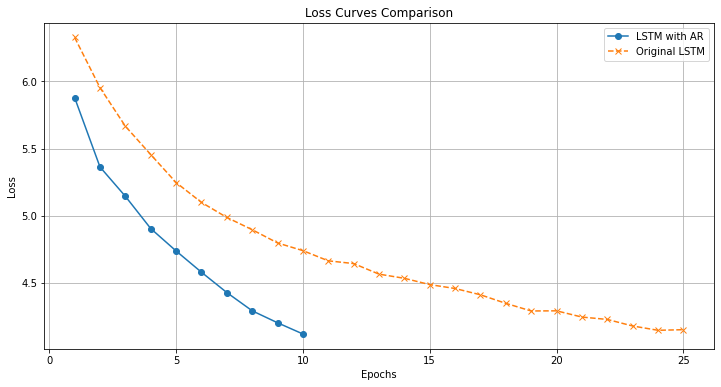

In [25]:
import matplotlib.pyplot as plt

# Losses for the first set of epochs
losses1 = [5.8793, 5.3630, 5.1448, 4.9047, 4.7379, 4.5795, 4.4282, 4.2923, 4.2031, 4.1197]

# Losses for the second set of epochs
losses2 = [6.3274, 5.9538, 5.6666, 5.4555, 5.2472, 5.0994, 4.9875, 4.8960, 4.7975, 4.7402, 4.6643, 4.6440, 4.5652, 4.5342, 4.4873, 4.4583, 4.4114, 4.3477, 4.2910, 4.2920, 4.2456, 4.2280, 4.1792, 4.1471, 4.1516]

# Epochs
epochs1 = list(range(1, len(losses1) + 1))
epochs2 = list(range(1, len(losses2) + 1))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the first set of losses
plt.plot(epochs1, losses1, marker='o', linestyle='-', label='LSTM with AR')

# Plot the second set of losses
plt.plot(epochs2, losses2, marker='x', linestyle='--', label='Original LSTM')

# Add title and labels
plt.title('Loss Curves Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Show the plot

plt.show()


### Submission

Upload a submission with the following files to Gradescope:
* hw1b.ipynb (rename to match this exactly)
* lstm_predictions.npy (this should also include all improvements from your exploration)
* neural_trigram_predictions.npy
* bigram_predictions.npy
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set perplexities shown by the autograder are on a completely different scale from your validation set perplexities due to truncating the distribution and selecting different text.  Don't worry if the values seem much worse.